In [1]:
import networkx as nx
import powerlaw as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter 

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [26]:
G = nx.read_edgelist('lastfm_asia_edges.txt', delimiter=',')

In [5]:
print(G)
# G.in_degree()

Graph with 7624 nodes and 27806 edges


In [6]:
def generate_ccdf(G):
    dd = Counter(dict(G.degree).values())
    dd = pd.DataFrame(list(dd.items()), columns = ("k", "count")).sort_values(by = "k")
    ccdf = dd.sort_values(by = "k", ascending = False)
    ccdf["cumsum"] = ccdf["count"].cumsum()
    ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
    ccdf = ccdf[["k", "ccdf"]].sort_values(by = "k")

    results = pl.Fit(ccdf["ccdf"])
    k_min = ccdf[ccdf["ccdf"] == results.power_law.xmin]["k"]
    print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, 
                                                                results.power_law.alpha, k_min))

   # Let's plot the best fit.
    ccdf["fit"] = (10 ** results.power_law.Kappa) * (ccdf["k"] ** -results.power_law.alpha)
    ax = plt.gca()
    ccdf.plot(kind = "line", x = "k", y = "ccdf", color = "#e41a1c", loglog = True, ax = ax)
    ccdf.plot(kind = "line", x = "k", y = "fit", color = "#377eb8", loglog = True, ax = ax)
    plt.ylim(bottom=0.0001)
    return None

In [7]:
def logscatter(G):
    d = dict(G.degree)
    # turn into a count of degree (the values of the dict)
    counter = Counter(d.values())
    # Make it into a dataframe
    counter = pd.DataFrame(list(counter.items()), columns = ("k", "count")).sort_values(by = "k")
    plt.scatter(np.log2(counter['k']), np.log2(counter['count']), c = 'blue', s=10, alpha=0.5)
    plt.title("log-log degree distr.")
    plt.savefig("loglog_degree_distribution.png")
    plt.show()
    return None

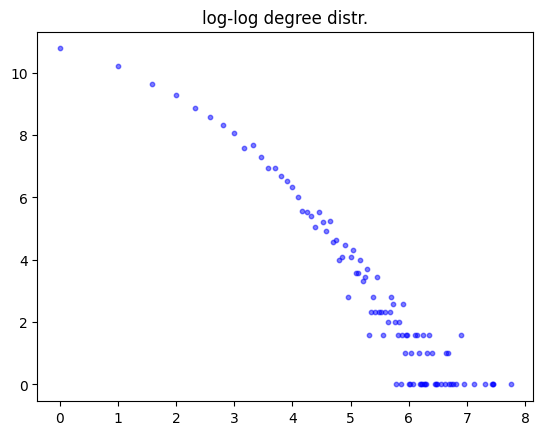

In [8]:
logscatter(G)

Calculating best minimal value for power law fit
Powerlaw CCDF Fit: 11.0660 x ^ -1.5454 (k_min = 69)


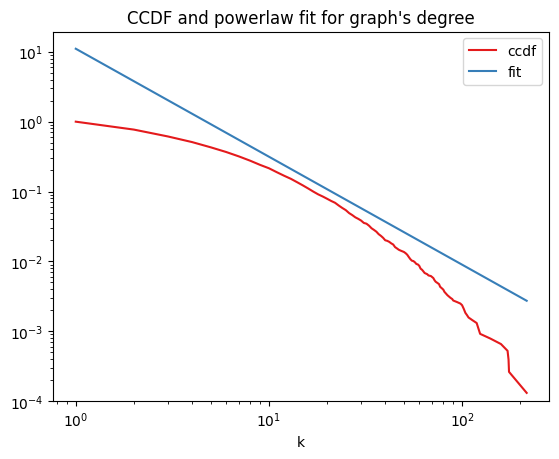

In [9]:
generate_ccdf(G)
plt.title("CCDF and powerlaw fit for graph's degree");

In [10]:
#global cluster coef = transitivity
trans = nx.transitivity(G)
print(f"Transitivity for full network: {trans}")

#nx.clustering = local cluster coef
cc = nx.clustering(G)
# print(f"CC for full network: {cc}")

#average cc
avgcc = sum(cc.values())/len(cc.values())
print(f"Average clustering coeff.: {avgcc}")

# def p(Graph):
#     return len(Graph.edges) / ((len(Graph.nodes) * (len(Graph.nodes)-1)) / 2)

# print("The parameter p for the graph: ", p(G))

Transitivity for full network: 0.178622548153384
Average clustering coeff.: 0.2194184243270858


In [11]:
#taking the largest strongly connected component
scc = max(nx.connected_components(G), key=len)

In [12]:
len(scc)

7624

In [13]:
ass = nx.degree_assortativity_coefficient(G)
ass

0.01707317256063152

In [14]:
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

communities = list(greedy_modularity_communities(G))

community_dict = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_dict[node] = i

modularity_value = modularity(G, [comm for comm in communities])
print("Modularity:", modularity_value)

Modularity: 0.7955830887901616


In [18]:
import community
partition = community.best_partition(G)

communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = [node]
    else:
        communities[comm_id].append(node)

cumnum = list(communities.keys())
print("Communities:", len(communities.keys()))
# cumnum.sort()
# print(cumnum)

Communities: 28


In [19]:
from networkx.algorithms import community
high_deg_node_dict = {}
for i in range(len(cumnum)):
    target_community = i
    nodes_in_community = [node for node, comm_id in partition.items() if comm_id == target_community]
    degrees = G.degree(nodes_in_community)
    node_with_highest_degree = max(degrees, key=lambda x: x[1])
    high_deg_node_dict[i] = node_with_highest_degree[0]
    #print("Node with the highest degree in the community:", node_with_highest_degree[0])

print("Highest degree nodes in each respective community: ", high_deg_node_dict)

Highest degree nodes in each respective community:  {0: '1792', 1: '4811', 2: '4785', 3: '6241', 4: '3530', 5: '7199', 6: '2854', 7: '5117', 8: '7237', 9: '1325', 10: '524', 11: '6101', 12: '1464', 13: '2805', 14: '5851', 15: '2337', 16: '1857', 17: '6859', 18: '7268', 19: '2160', 20: '1674', 21: '4356', 22: '6817', 23: '5461', 24: '7501', 25: '7557', 26: '7480', 27: '2019'}


In [20]:
community_sizes = {comm_id: sum(1 for node in partition.values() if node == comm_id) 
                  for comm_id in set(partition.values())}
largest_community_id = max(community_sizes, key=community_sizes.get)
print("The largest community's ID is:", largest_community_id)
#community_sizes

The largest community's ID is: 11


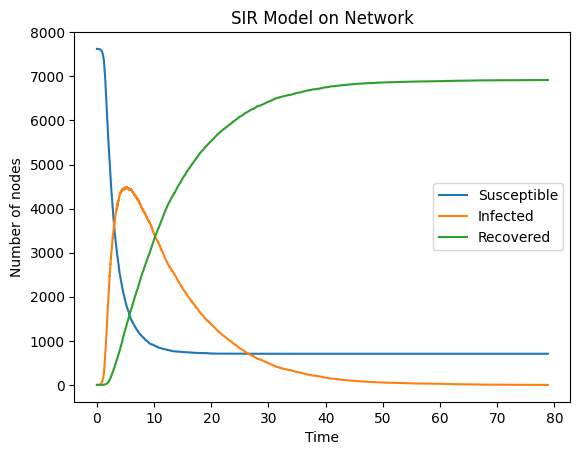

In [30]:
import networkx as nx
import EoN
import matplotlib.pyplot as plt

# Parameters
beta = 0.3  # transmission rate
gamma = 0.1  # recovery rate
initial_infected = [1] #starting point 
G = nx.convert_node_labels_to_integers(G, first_label=0)

# Run the SIR model on the network
t, S, I, R = EoN.fast_SIR(G, beta, gamma, initial_infecteds = initial_infected)

# Plot the results
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of nodes')
plt.title('SIR Model on Network')
plt.legend()
plt.show()
